# B regressor final training

## Import

### Import modules

In [38]:
#comentario aleatorio para dewatafuckizar isto
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K
from __future__ import division ,print_function
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

### Import data
Here just looking at mu tau_h b b final-state

In [39]:
mode = "mu_tau_b_b"
loc = './../../../../../data_n/'
SignalData = []
BackgroundData = []

energies = ['260', '270', '280', '300', '320', '400', '500', '550', '600' ,'700']
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(loc + back + "_TuneCUETP8M1_13TeV.csv")
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X

data = cleanData(data)

Samples contains 10417 signal events and 168053 background events
178470 events in total


### Process data and add new features

In [40]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum
 

moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [41]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


### Specify variables

In [42]:

genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
print(trainFeatures)

['t_0_pT', 't_0_eta', 't_0_phi', 't_0_mass', 't_1_pT', 't_1_eta', 't_1_phi', 't_1_mass', 'b_0_pT', 'b_0_eta', 'b_0_phi', 'b_0_mass', 'b_0_csv', 'b_1_pT', 'b_1_eta', 'b_1_phi', 'b_1_mass', 'b_1_csv', 'mPT_pT', 'mPT_phi', 'h_tt_pT', 'h_tt_eta', 'h_tt_phi', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_pT', 'h_bb_eta', 'h_bb_phi', 'h_bb_mass', 'diH_pT', 'diH_eta', 'diH_phi', 'diH_mass', 'diH_kinFit_mass', 'diH_kinFit_prob', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|

In [43]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]

#other = [var for var in trainFeatures for x in ['Fit', 'csv'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]
print(trainFeatures)

['t_0_mass', 't_1_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_mT']


In [44]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures ]

In [45]:
set0 = [var for var in fsFeatures if var not in epFeatures]   
set1 = [var for var in fsFeatures]  
set2 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + epFeatures] + ['hl_mT']
set3 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi] + ['hl_mT']

## Specify options

In [46]:
regTrainFeatures = set3
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_b_0_px', 'gen_b_0_py', 'gen_b_0_pz', 'gen_b_1_px', 'gen_b_1_py', 'gen_b_1_pz']
print ("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print ("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])


Training on 52 features: ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_1_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'hl_mT']

Regressing to 6 features: ['gen_b_0_px', 'gen_b_0_py', 'gen_b_0_pz', 'gen_b_1_px', 'gen_b_1_py', 'gen_b_1_pz']


## Define regressor

In [47]:
def getLayout(params):
    architecture = int(params[0])
    nodes = int(params[1])
    depth = int(params[2])
    layout = np.zeros(depth).astype(int)
    if architecture == 0: #Box: same number of nodes in each layer
        layout.fill(nodes)
    if architecture == 1: #Taper: linear reduction of width with depth
        coef = (len(regTargetFeatures)-nodes)/(depth+1)
        for l in range(depth):
            layout[l] = nodes+(coef*l)
    if architecture == 2: #Choke: linear reduction down to Noutputs at centre layer
        centre = int(math.ceil(depth/2))
        coefRed = (len(regTargetFeatures)-nodes)/(centre)
        coefInc = (nodes-len(regTargetFeatures))/(depth-centre)
        mod = -1
        if (depth % 2 == 0) and (depth != 2):
            mod = 1
        for l in range(centre+mod):
            layout[l] = nodes+(coefRed*l)
        for l in range(centre+mod, depth):
            layout[l] = len(regTargetFeatures)+(coefInc*(l-centre+1))
    if architecture == 3: #Funnel: linearly reduces to Noutputs at centre layer then moves to box layput
        centre = int(math.ceil(depth/2))
        coefRed = (len(regTargetFeatures)-nodes)/(centre)
        mod = -1
        if (depth % 2 == 0) and (depth != 2):
            mod = 1
        for l in range(centre+mod):
            layout[l] = nodes+(coefRed*l)
        for l in range(centre+mod, depth):
            layout[l] = len(regTargetFeatures)
    return layout

In [48]:
def getParameterisedRegressor(params):
    params = params.tolist()
    noise = params[0]
    dropout = params[1]
    layers = getLayout(params[2:])
    regModel = Sequential()
    regModel.add(Dense(int(layers[0]), input_dim=len(regTrainFeatures), init='glorot_normal'))
    regModel.add(PReLU())
    regModel.add(GaussianNoise(noise))
    regModel.add(BatchNormalization())
    regModel.add(Dropout(dropout))
    for i in layers[1:]:
        if i < len(regTargetFeatures): break
        regModel.add(Dense(int(i), init='glorot_normal'))
        regModel.add(PReLU())
        regModel.add(GaussianNoise(noise))
        regModel.add(BatchNormalization())
        regModel.add(Dropout(dropout))
    regModel.add(Dense(len(regTargetFeatures), activation='linear', init='glorot_normal'))
    regModel.compile(loss='mse', optimizer='nadam')
    modelVersion = "model0"
    return regModel

In [49]:
compileArgs = {'loss' : 'mse', 'optimizer' : 'nadam'}

def getRegressor(model):
    regModel = Sequential()
    if model == "model0":
        regModel.add(Dense(70, input_dim=len(regTrainFeatures), kernel_initializer='glorot_normal', activation='selu'))
        regModel.add(Dense(70, kernel_initializer='glorot_normal', activation='selu'))
        regModel.add(Dense(70, kernel_initializer='glorot_normal', activation='selu'))
        regModel.add(Dense(70, kernel_initializer='glorot_normal', activation='selu'))
        regModel.add(Dense(70, kernel_initializer='glorot_normal', activation='selu'))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model1":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model2":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model3":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model4":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_uniform'))
    elif model == "model5":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model6":
        regModel.add(Dense(150, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(120, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal')) 
    elif model == "model7":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(100, kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(100, kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model8":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model9":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model10":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    regModel.compile(**compileArgs)
    return regModel

## Evaluation

### Calculate invariant mass of b pair and pull

In [50]:
def calcMass(pred):
    tmpData = pandas.DataFrame(np.nan, index=[x for x in range(len(pred))], columns=['ID'])
    for n, feature in enumerate(regTargetFeatures):
        tmpData['reg_' + feature[4:]] = pandas.Series(pred[:,n], index=tmpData.index)
    bMass = 4.8
    tmpData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(tmpData.loc[:,'reg_b_0_px'])+np.square(tmpData.loc[:,'reg_b_0_py'])+np.square(tmpData.loc[:,'reg_b_0_pz']))
    tmpData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(tmpData.loc[:,'reg_b_1_px'])+np.square(tmpData.loc[:,'reg_b_1_py'])+np.square(tmpData.loc[:,'reg_b_1_pz']))
    tmpData['reg_h_bb_px'] = tmpData.loc[:,'reg_b_0_px']+tmpData.loc[:,'reg_b_1_px']
    tmpData['reg_h_bb_py'] = tmpData.loc[:,'reg_b_0_py']+tmpData.loc[:,'reg_b_1_py']
    tmpData['reg_h_bb_pz'] = tmpData.loc[:,'reg_b_0_pz']+tmpData.loc[:,'reg_b_1_pz']
    tmpData['reg_h_bb_E'] = tmpData.loc[:,'reg_b_0_E']+tmpData.loc[:,'reg_b_1_E']
    tmpData['reg_h_bb_p2'] = np.square(tmpData.loc[:,'reg_h_bb_px'])+np.square(tmpData.loc[:,'reg_h_bb_py'])+np.square(tmpData.loc[:,'reg_h_bb_pz'])
    tmpData['reg_h_bb_mass'] = np.sqrt(np.square(tmpData.loc[:,'reg_h_bb_E'])-tmpData.loc[:,'reg_h_bb_p2'])
    return tmpData['reg_h_bb_mass']

In [51]:
def getResponse(pred):
    masses = calcMass(pred)
    pull = 125-masses.values
    return (abs(pull.mean()), pull.std())

### Preprocess data

In [52]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)



In [53]:
X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))

### Train regressors
Train nSplit times to find best convergence

In [54]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [55]:
trainParams = {'epochs' : 10000, 'batch_size' : 64, 'verbose' : 0}

In [56]:
start = time.time()
results = []
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")
if cvTests:
    kf = KFold(n_splits=nSplits, shuffle=True)
    i = 0
    for train, test in kf.split(X_reg):
        i += 1
        print ("Running fold", i, "/", nSplits)
        model = None # Clearing the NN
        model = getRegressor(regModel)
        model.reset_states #Just checking
        trainingData = (X_reg[train], y_reg[train])
        lossHistory = LossHistory()
        earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        model.fit(X_reg[train], y_reg[train],
                  validation_data = (X_reg[test], y_reg[test]),
                  callbacks = [earlyStop, saveBest, lossHistory],
                  **trainParams)
        histories.append(lossHistory.losses)
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['mean'], results[-1]['std'] = getResponse(outputPipe.inverse_transform(model.predict(X_reg[test], verbose=0)))
        results[-1]['loss'] = model.evaluate(X_reg[test], y_reg[test], verbose=0)
        print ("Score is:", results[-1])
        model.save('train_weights/train_' + str(i-1) + '.h5')
else :
    for i in range(nSplits):
        print ("Running fold", i+1, "/", nSplits)
        model = None # Clearing the NN.
        model = getRegressor(regModel)
        model.reset_states #Just checking
        earlyStop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        histories.append(model.fit(X_reg, y_reg,
                  callbacks = [earlyStop, saveBest],
                  **trainParams))
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['mean'], results[-1]['std'] = getResponse(outputPipe.inverse_transform(model.predict(X_reg, verbose=0)))
        results[-1]['loss'] = model.evaluate(X_reg, y_reg, verbose=0)
        print ("Score is:", results[-1])
        model.save('train_weights/train_' + str(i) + '.h5')
with open('train_weights/resultsFile.pkl', 'w') as fout:
    pickle.dump(results, fout)
print ("Cross-validation took {:.3f}s ".format(time.time() - start))
X_reg = None
y_reg = None
train = None
test = None
model.summary()
model = None

Running fold 1 / 10
Epoch 00039: early stopping
Score is: {'std': 21.65729, 'loss': 0.047806787349605986, 'mean': 5.860003}
Running fold 2 / 10
Epoch 00044: early stopping
Score is: {'std': 25.62491, 'loss': 0.0647346582168917, 'mean': 3.0438685}
Running fold 3 / 10
Epoch 00023: early stopping
Score is: {'std': 27.104818, 'loss': 0.06023847667201785, 'mean': 0.49649692}
Running fold 4 / 10
Epoch 00034: early stopping
Score is: {'std': 24.121805, 'loss': 0.050805384146272378, 'mean': 1.524318}
Running fold 5 / 10
Epoch 00046: early stopping
Score is: {'std': 25.051466, 'loss': 0.050050454636035684, 'mean': 1.4135166}
Running fold 6 / 10
Epoch 00031: early stopping
Score is: {'std': 26.054213, 'loss': 0.058015540393860893, 'mean': 0.25767106}
Running fold 7 / 10
Epoch 00028: early stopping
Score is: {'std': 23.982979, 'loss': 0.04804404741082028, 'mean': 5.099659}
Running fold 8 / 10
Epoch 00019: early stopping
Score is: {'std': 25.041565, 'loss': 0.062130547699734154, 'mean': 7.1438727}

### Plot training histories

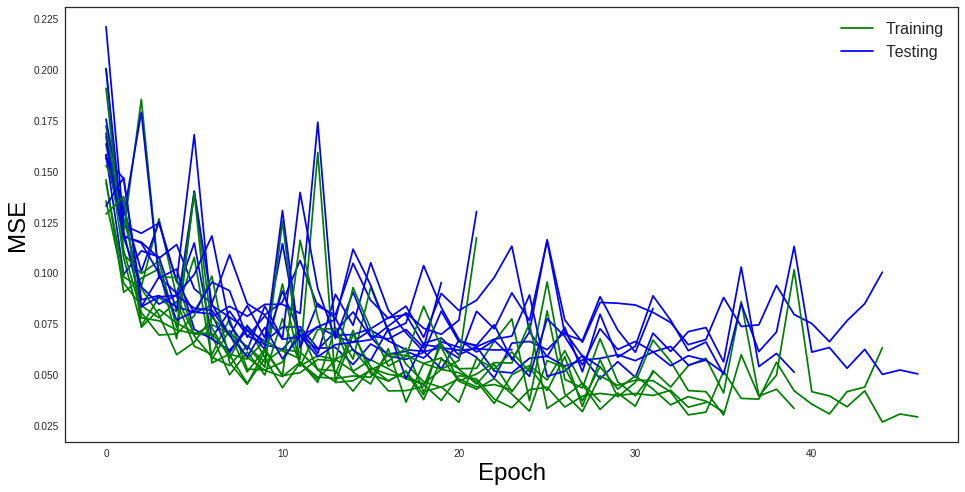

In [57]:
plt.figure(figsize=(16,8))
if cvTests:
    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Testing')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')
    plt.legend(fontsize=16)
else:
    for history in histories:
        plt.plot(history.history['loss'])
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("MSE", fontsize=24, color='black')

## Construct ensemble

In [58]:
results = None
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [59]:
def loadModel(cycle, location='train_weights/train_'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [60]:
def getWeights(value, met):
    return 1/value

In [61]:
ensemble = []
weights = []
print ("Choosing ensemble by", ensembleMode)
if ensembleMode == 'mix':
    for met in results[0]:
        print ("Choosing best for metric", met)
        cycle = np.argmin([result[met] for result in results])
        print (met, "Model", "is", cycle, "with", met, "=", results[cycle][met])
        ensemble.append(loadModel(cycle))
        weights.append(1)
else:
    dtype = [('cycle', int), ('result', float)]
    values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    for i in range(min([ensembleSize, len(results)])):
        ensemble.append(loadModel(values[i]['cycle']))
        weights.append(getWeights(values[i]['result'], ensembleMode))
        print ("Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result'])
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 0 with loss = 0.0478067873496
Model 1 is 6 with loss = 0.0480440474108
Model 2 is 8 with loss = 0.0491014928842
Model 3 is 4 with loss = 0.050050454636
Model 4 is 3 with loss = 0.0508053841463
Model 5 is 9 with loss = 0.0577118962395
Model 6 is 5 with loss = 0.0580155403939
Model 7 is 2 with loss = 0.060238476672
Model 8 is 7 with loss = 0.0621305476997
Model 9 is 1 with loss = 0.0647346582169


# Save

In [62]:
name = "weights/NN_B_Regressor_App_" + mode + "_" 
print (name)

weights/NN_B_Regressor_App_mu_tau_b_b_


In [63]:
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string)
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'w') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'w') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'w') as fout:
    pickle.dump(outputPipe, fout)

## Response of ensemble on development data

###  Preprocess data

In [64]:
X_dev = inputPipe.transform(devData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [65]:
pred = np.zeros((len(devData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_dev, verbose=0)) 

In [66]:
for n, feature in enumerate(regTargetFeatures):
    devData['reg_' + feature[4:]] = pandas.Series(pred[:,n], index=devData.index)
bMass = 4.8
devData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(devData.loc[:,'reg_b_0_px'])+np.square(devData.loc[:,'reg_b_0_py'])+np.square(devData.loc[:,'reg_b_0_pz']))
devData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(devData.loc[:,'reg_b_1_px'])+np.square(devData.loc[:,'reg_b_1_py'])+np.square(devData.loc[:,'reg_b_1_pz']))
devData['reg_h_bb_px'] = devData.loc[:,'reg_b_0_px']+devData.loc[:,'reg_b_1_px']
devData['reg_h_bb_py'] = devData.loc[:,'reg_b_0_py']+devData.loc[:,'reg_b_1_py']
devData['reg_h_bb_pz'] = devData.loc[:,'reg_b_0_pz']+devData.loc[:,'reg_b_1_pz']
devData['reg_h_bb_E'] = devData.loc[:,'reg_b_0_E']+devData.loc[:,'reg_b_1_E']
devData['reg_h_bb_p2'] = np.square(devData.loc[:,'reg_h_bb_px'])+np.square(devData.loc[:,'reg_h_bb_py'])+np.square(devData.loc[:,'reg_h_bb_pz'])
devData['reg_h_bb_mass'] = np.sqrt(np.square(devData.loc[:,'reg_h_bb_E'])-devData.loc[:,'reg_h_bb_p2'])

### Evaluate response

In [67]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.loc[:, 'loss_d'] += np.square(devData.loc[:, 'reg_' + feature[4:]]-devData.loc[:, feature])
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(devData[:]['reg_h_bb_mass'].values, len(devData), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
print ('Ensemble on dev data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(devData.loc[:, 'loss_d'])/len(regTargetFeatures), meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))

Ensemble on dev data:
 Loss = 326.942740985, Mean = 120.444519572 +- 0.020988787752, sigma = 11.5260768398 +- 0.023443274929


## Response of ensemble on validation data

###  Preprocess data

In [68]:
X_val = inputPipe.transform(valData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [69]:
pred = np.zeros((len(valData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_val, verbose=0)) 

In [70]:
for n, feature in enumerate(regTargetFeatures):
    valData['reg_' + feature[4:]] = pandas.Series(pred[:,n], index=valData.index)
bMass = 4.8
valData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(valData.loc[:,'reg_b_0_px'])+np.square(valData.loc[:,'reg_b_0_py'])+np.square(valData.loc[:,'reg_b_0_pz']))
valData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(valData.loc[:,'reg_b_1_px'])+np.square(valData.loc[:,'reg_b_1_py'])+np.square(valData.loc[:,'reg_b_1_pz']))
valData['reg_h_bb_px'] = valData.loc[:,'reg_b_0_px']+valData.loc[:,'reg_b_1_px']
valData['reg_h_bb_py'] = valData.loc[:,'reg_b_0_py']+valData.loc[:,'reg_b_1_py']
valData['reg_h_bb_pz'] = valData.loc[:,'reg_b_0_pz']+valData.loc[:,'reg_b_1_pz']
valData['reg_h_bb_E'] = valData.loc[:,'reg_b_0_E']+valData.loc[:,'reg_b_1_E']
valData['reg_h_bb_p2'] = np.square(valData.loc[:,'reg_h_bb_px'])+np.square(valData.loc[:,'reg_h_bb_py'])+np.square(valData.loc[:,'reg_h_bb_pz'])
valData['reg_h_bb_mass'] = np.sqrt(np.square(valData.loc[:,'reg_h_bb_E'])-valData.loc[:,'reg_h_bb_p2'])

### Evaluate response

In [71]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.loc[sig, 'loss_v'] += np.square(valData.loc[sig, 'reg_' + feature[4:]]-valData.loc[sig, feature])
meanBootReg = []
stvalBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['reg_h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stvalBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stvalReg = (np.mean(stvalBootReg), np.std(stvalBootReg)/math.sqrt(len(stvalBootReg)))
print ('Ensemble on val data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(valData.loc[sig, 'loss_v'])/len(regTargetFeatures), meanReg[0], meanReg[1], stvalReg[0], stvalReg[1]))

Ensemble on val data:
 Loss = 821.241381367, Mean = 118.289322839 +- 0.0504467894348, sigma = 15.18832801 +- 0.0748987052654


### Momentum distributions


gen_b_0_px


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_0_py


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_0_pz


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_1_px


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_1_py


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_1_pz


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


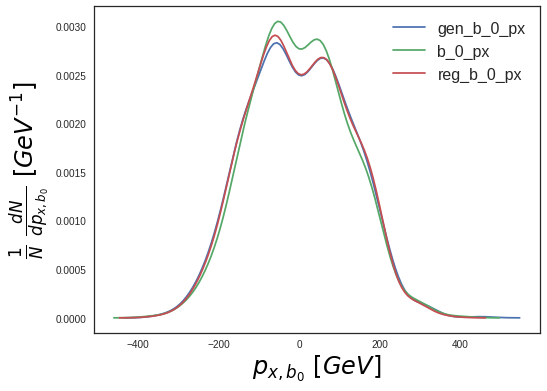

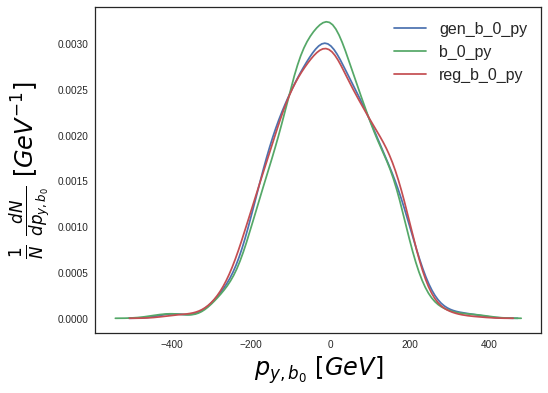

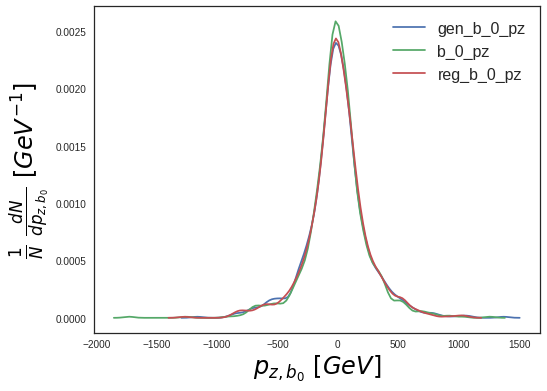

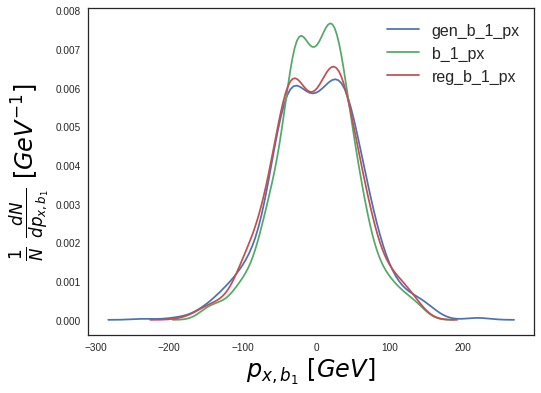

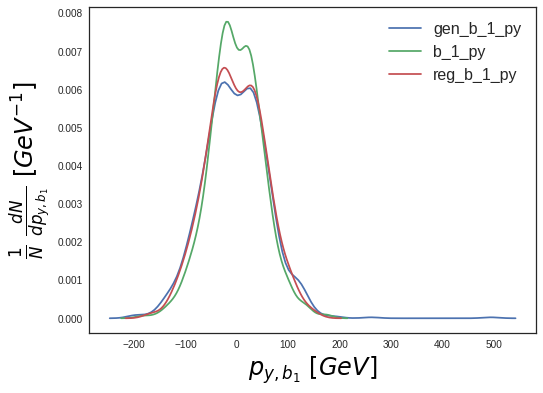

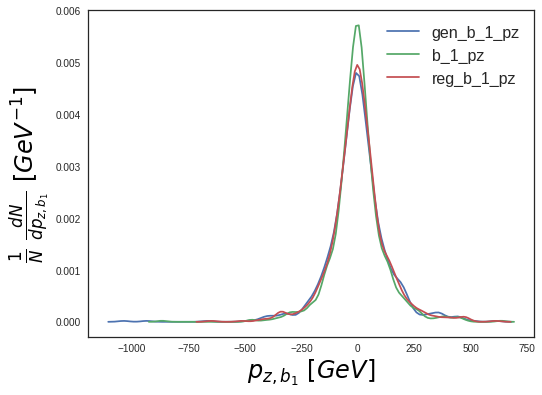

In [72]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    plt.figure(figsize=(8, 6))
  
    bootGen = []
    meanBootGen = []
    stdevBootGen = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature].values, len(valData[sig]), replace=True)
        meanBootGen.append(points.mean())
        stdevBootGen.append(points.std())
    meanGen = (np.mean(meanBootGen), np.std(meanBootGen)/math.sqrt(len(meanBootGen)))
    stdevGen = (np.mean(stdevBootGen), np.std(stdevBootGen)/math.sqrt(len(stdevBootGen)))
    sns.kdeplot(valData[sig][feature])
    bootRec = []
    meanBootRec = []
    stdevBootRec = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature[4:]].values, len(valData[sig]), replace=True)
        meanBootRec.append(points.mean())
        stdevBootRec.append(points.std())
    meanRec = (np.mean(meanBootRec), np.std(meanBootRec)/math.sqrt(len(meanBootRec)))
    stdevRec = (np.mean(stdevBootRec), np.std(stdevBootRec)/math.sqrt(len(stdevBootRec)))
    sns.kdeplot(valData[sig][feature[4:]])
    bootReg = []
    meanBootReg = []
    stdevBootReg = []
    for i in range(100):
        points = np.random.choice(valData[sig]["reg_" + feature[4:]].values, len(valData[sig]), replace=True)
        meanBootReg.append(points.mean())
        stdevBootReg.append(points.std())
    meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
    stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
    sns.kdeplot(valData[sig]["reg_" + feature[4:]])
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()


gen_b_0_px


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_0_py

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)




gen_b_0_pz


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_1_px


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_1_py


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)



gen_b_1_pz


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


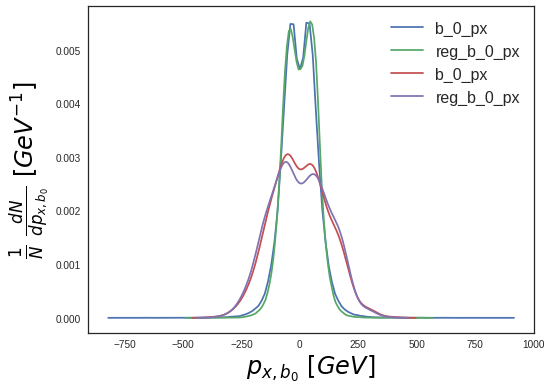

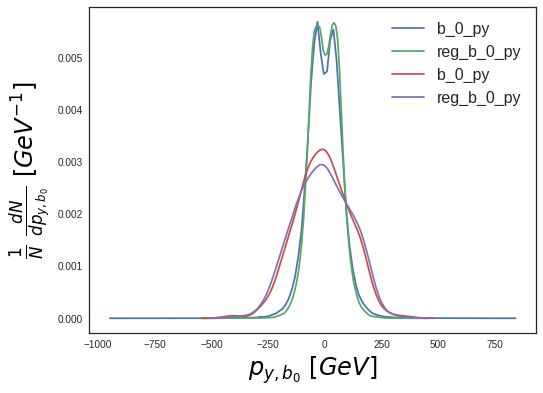

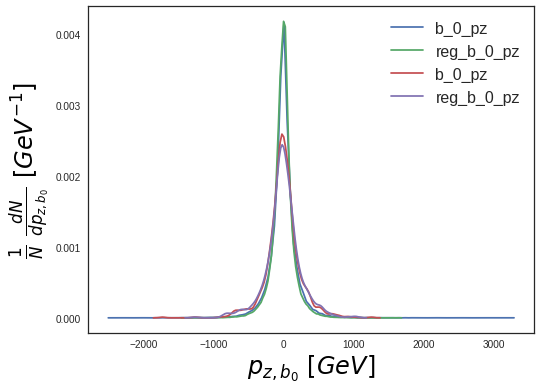

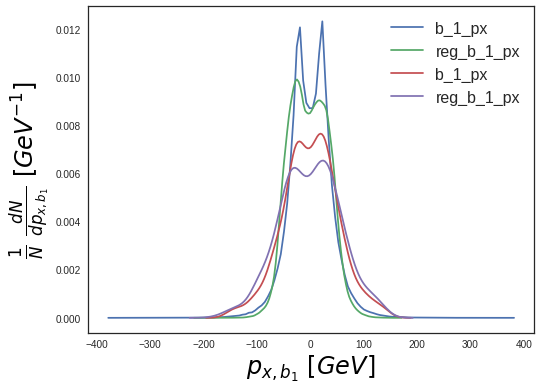

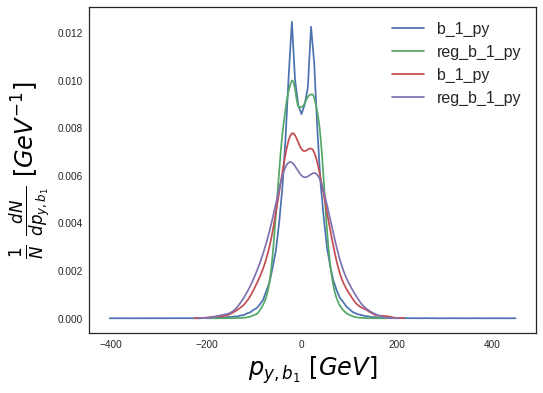

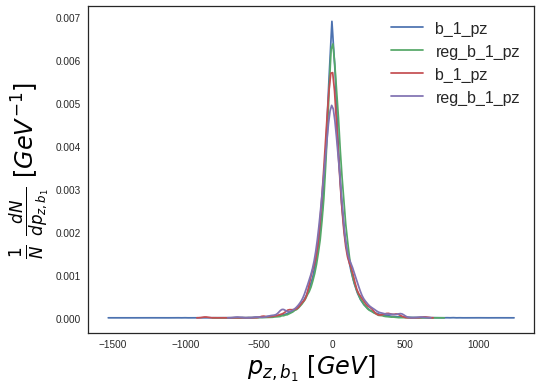

In [73]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    plt.figure(figsize=(8, 6))
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[bkg][feature[4:]].values, len(valData[bkg]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[bkg][feature[4:]])
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[bkg]["reg_" + feature[4:]].values, len(valData[bkg]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[bkg]["reg_" + feature[4:]])
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature[4:]].values, len(valData[sig]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[sig][feature[4:]])
    boot = [];
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[sig]["reg_" + feature[4:]].values, len(valData[sig]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[sig]["reg_" + feature[4:]])
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Momentum pull distributions

	Feature	mean					sigma
Reco:	b_0_px	0.843236772427 +- 0.0713346992921	23.2097024421 +- 0.180125352297
Reg:	b_0_px	-0.445751333783 +- 0.0668285051969	19.4962639621 +- 0.109481641587


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages

Reco:	b_0_py	-0.278234137659 +- 0.0796554756115	25.2017469593 +- 0.303589833807
Reg:	b_0_py	-0.760394340998 +- 0.0699481415112	20.0702636399 +- 0.0941551806956
Reco:	b_0_pz	-0.646608391502 +- 0.236965289063	70.953319077 +- 1.72893879733
Reg:	b_0_pz	0.322919568067 +- 0.117406449468	42.4904843422 +- 0.353938560515
Reco:	b_1_px	-0.525203942425 +- 0.0600264357512	19.5262244022 +- 0.17186134036


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/an

Reg:	b_1_px	-1.91403943424 +- 0.0478030192663	15.261166841 +- 0.161470016272
Reco:	b_1_py	0.604891066716 +- 0.0690100138223	22.6599593659 +- 0.449787048098
Reg:	b_1_py	-0.164985481349 +- 0.0628351313477	18.348895296 +- 0.465975834519
Reco:	b_1_pz	1.31897849392 +- 0.18291797604	49.0699926265 +- 0.929330107573
Reg:	b_1_pz	2.86006338532 +- 0.128431229518	39.6475271018 +- 0.809462646872


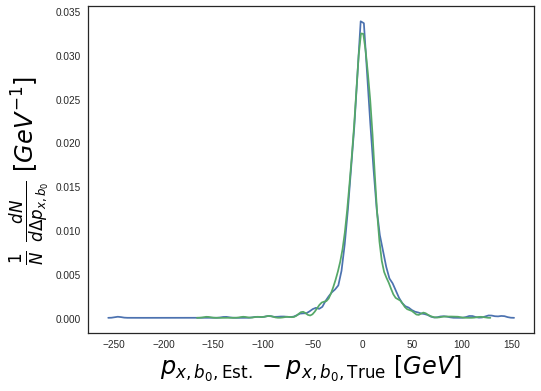

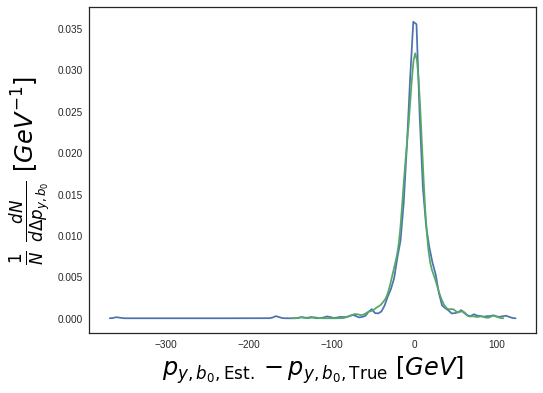

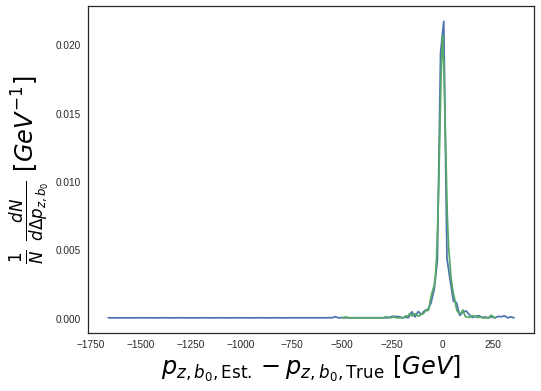

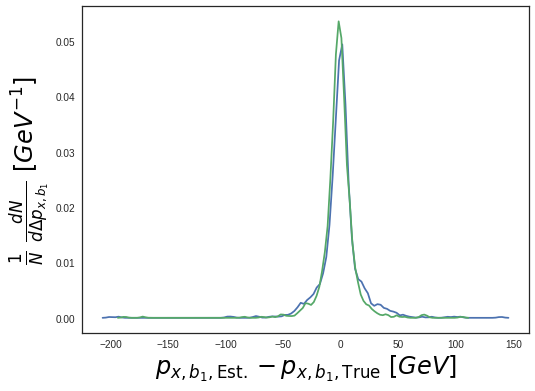

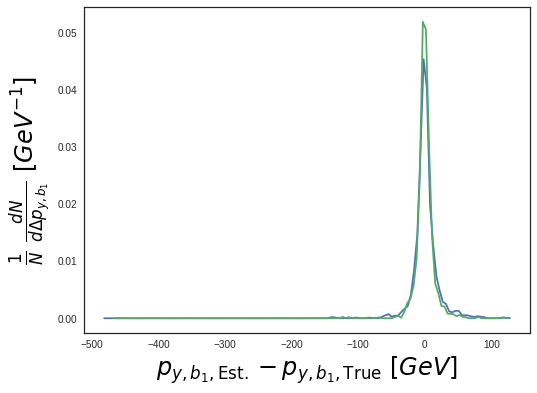

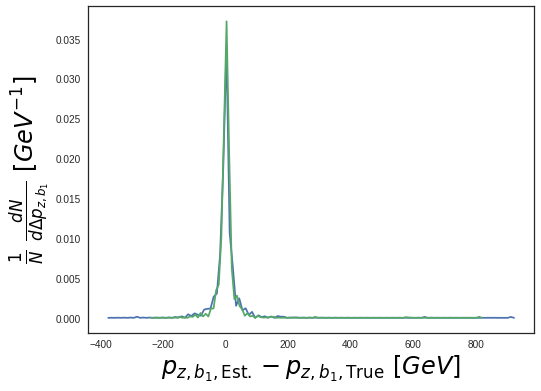

In [74]:
print ("\tFeature\tmean\t\t\t\t\tsigma")
for n, feature in enumerate(regTargetFeatures):
    plt.figure(figsize=(8, 6))
    
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig][feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print ("Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))
    sns.kdeplot(data=pullVal)
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig]['reg_' + feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
       
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print ("Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))
    sns.kdeplot(data=pullVal)
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Two-sample Kolmogorov–Smirnov test

In [75]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['reg_' + feature[4:]].values)
    print ("K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1]))


gen_b_0_px
K-S test result 0.0153, p-value of 0.9998

gen_b_0_py
K-S test result 0.0163, p-value of 0.9994

gen_b_0_pz
K-S test result 0.0183, p-value of 0.9963

gen_b_1_px
K-S test result 0.0295, p-value of 0.7799

gen_b_1_py
K-S test result 0.0214, p-value of 0.9771

gen_b_1_pz
K-S test result 0.0224, p-value of 0.9646


### Higgs mass distribution

In [76]:

bootReg = []
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['reg_h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice(valData[sig]['h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
    
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
print ("Distribution\t\tmean\tsigma")
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
print ('Reconstructed Signal,  Mean = {:.2f} +- {:.2f}, sigma = {:.2f} +- {:.2f}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

Distribution		mean	sigma
Regressed Signal, Mean = 118.446062321 +- 0.0405301229998, sigma = 15.0578875206 +- 0.0893117777534
Reconstructed Signal,  Mean = 113.50 +- 0.08, sigma = 27.40 +- 0.32


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


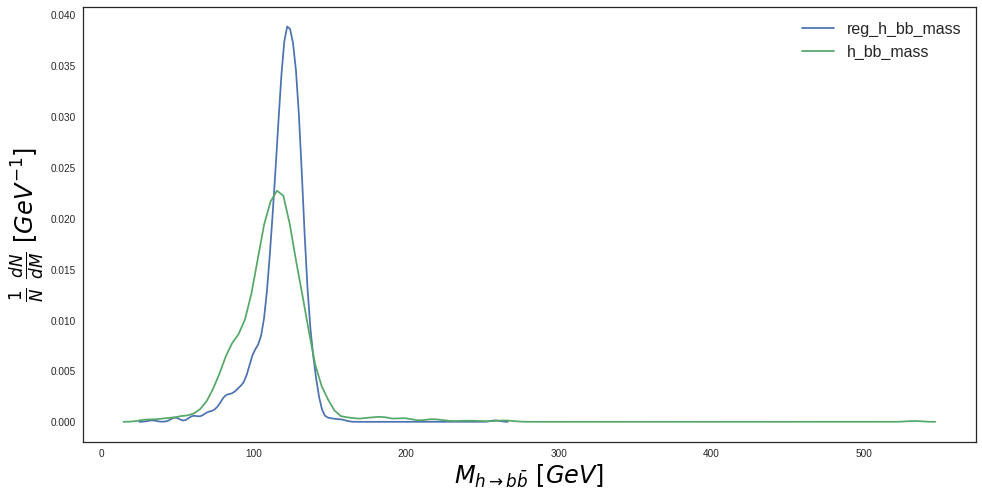

In [77]:

plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData[sig]['reg_h_bb_mass'])
sns.kdeplot(data=valData[sig]['h_bb_mass'])
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [78]:
bootReg = []
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice((valData[sig]['reg_h_bb_mass'].values-125)/125, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice((valData[sig]['h_bb_mass'].values-125)/125, len(valData[sig]), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
print ("Distribution\t\tmean\tsigma")
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
print ('Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

Distribution		mean	sigma
Regressed Signal, Mean = -0.0533217412781 +- 0.000389987077457, sigma = 0.122227499154 +- 0.000686673421506
Reconstructed Signal,  Mean = -0.0917582746835 +- 0.000671101705958, sigma = 0.220707345362 +- 0.00250771342668


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


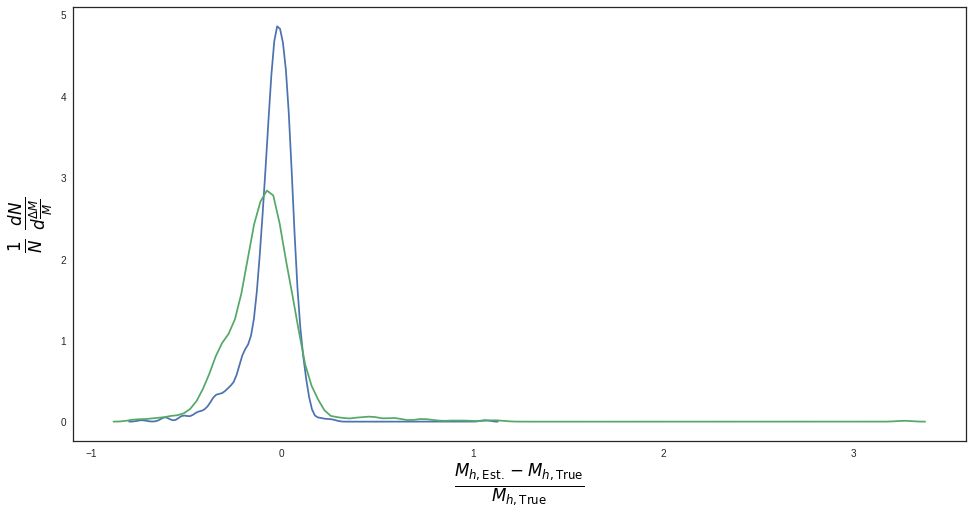

In [79]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.kdeplot(data=(valData[sig]['reg_h_bb_mass'].values-125)/125)
sns.kdeplot(data=(valData[sig]['h_bb_mass'].values-125)/125)
plt.legend(fontsize=16)
plt.xlabel(r"$\frac{M_{h,\mathrm{Est.}}-M_{h,\mathrm{True}}}{M_{h,\mathrm{True}}}$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\frac{\Delta M}{M}}$", fontsize=24, color='black')
plt.show()

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


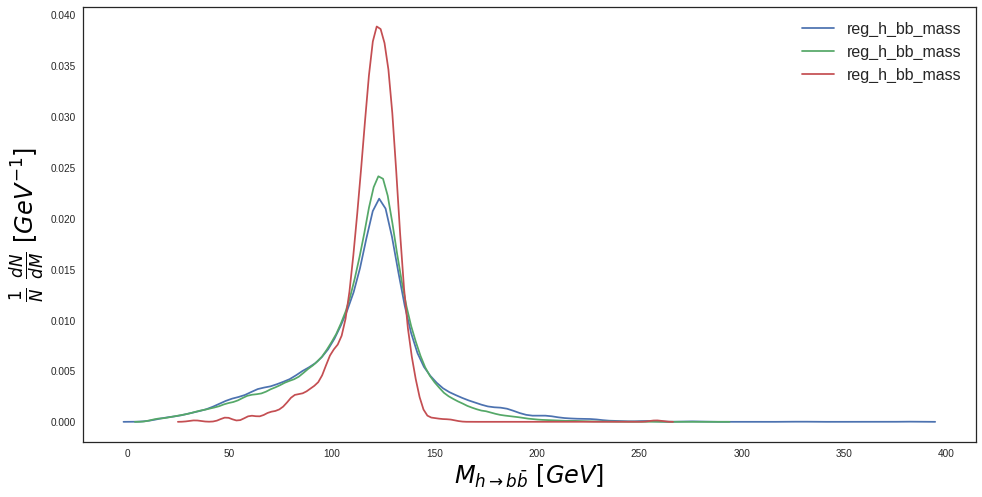

In [80]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData[sigMM]['reg_h_bb_mass'])
sns.kdeplot(data=valData[bkg]['reg_h_bb_mass'])
sns.kdeplot(data=valData[sig]['reg_h_bb_mass'])
plt.legend(fontsize=16)

plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [81]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[bkg, 'h_bb_mass'], 'x':xPlot, 'name':'bkg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[bkg, 'reg_h_bb_mass'], 'x':xPlot, 'name':'bkg_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'h_bb_mass'], 'x':xPlot, 'name':'sig', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'reg_h_bb_mass'], 'x':xPlot, 'name':'sig_reg', 'kde':1, 'mean':1, 'std':1}])

In [82]:
meanReco = (np.mean(plots['sig' + '_mean']),
            np.std(plots['sig' + '_mean'])/math.sqrt(len(plots['sig' + '_mean'])))
stdReco = (np.mean(plots['sig' + '_std']),
             np.std(plots['sig' + '_std'])/math.sqrt(len(plots['sig' + '_std'])))
meanReg = (np.mean(plots['sig_reg' + '_mean']),
            np.std(plots['sig_reg' + '_mean'])/math.sqrt(len(plots['sig_reg' + '_mean'])))
stdReg = (np.mean(plots['sig_reg' + '_std']),
             np.std(plots['sig_reg' + '_std'])/math.sqrt(len(plots['sig_reg' + '_std'])))

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


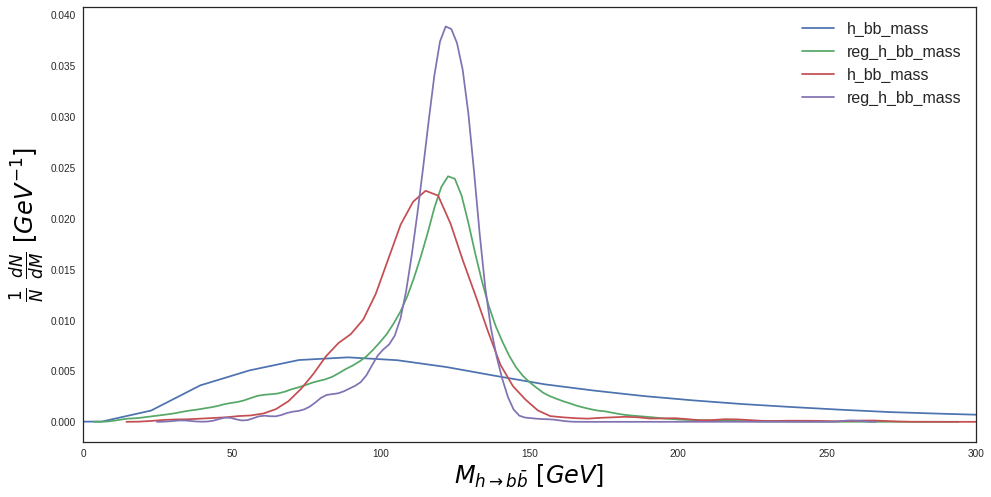

In [95]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[bkg, 'h_bb_mass'])
sns.kdeplot(data=valData.loc[bkg, 'reg_h_bb_mass'])
sns.kdeplot(data=valData.loc[sig, 'h_bb_mass'],)
sns.kdeplot(data=valData.loc[sig, 'reg_h_bb_mass'])

plt.legend(fontsize=16)
plt.xlim(0,300)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### ROC Curve

In [84]:
print ('Reg:', roc_auc_score(valData.loc[sig|bkg, 'gen_target'], -np.abs(125-valData.loc[sig|bkg, 'reg_h_bb_mass'])))
print ('Reco:', roc_auc_score(valData.loc[sig|bkg, 'gen_target'], -np.abs(125-valData.loc[sig|bkg, 'h_bb_mass'])))

Reg: 0.654919619427
Reco: 0.80185646393


/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


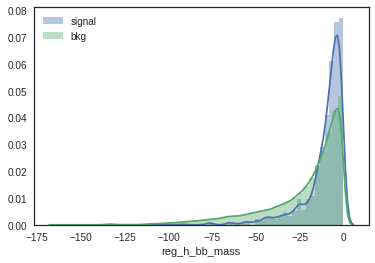

In [85]:
sns.distplot(-np.abs(125-valData.loc[sig, 'reg_h_bb_mass']), label='signal')
sns.distplot(-np.abs(125-valData.loc[bkg, 'reg_h_bb_mass']), label='bkg')
plt.legend()

## Classifier response

### Train

In [86]:
classFeatures = ['b_0_mass', 'b_1_mass', 't_0_mass', 't_1_mass', 't_0_px', 't_0_py', 't_0_pz', 't_1_px', 't_1_py', 't_1_pz', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 'mPT_px', 'mPT_py', 'b_0_|p|', 'b_0_E', 'b_1_|p|', 'b_1_E', 't_0_|p|', 't_0_E', 't_1_|p|', 't_1_E', 'diH_mass', 'h_tt_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'h_bb_|p|', 'h_bb_E', 'h_tt_|p|', 'h_tt_E', 'hl_mT']

In [87]:
recoFeatures = ['h_bb_mass']#, 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['h_bb_mass']
#recoFeatures = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['h_bb_mass']
recoFeatures = classFeatures + ['h_bb_mass']
recoClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
recoClass.fit(valData[recoFeatures], valData['gen_target'].values.astype('int'))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=-999.0, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [88]:
%%time
regFeatures = ['reg_h_bb_mass']#, 'reg_b_0_px', 'reg_b_0_py', 'reg_b_0_pz', 'reg_b_1_px', 'reg_b_1_py', 'reg_b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['reg_h_bb_mass']
#regFeatures = ['reg_b_0_px', 'reg_b_0_py', 'reg_b_0_pz', 'reg_b_1_px', 'reg_b_1_py', 'reg_b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['reg_h_bb_mass']
regFeatures = classFeatures + ['reg_h_bb_mass']
regClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
regClass.fit(valData[regFeatures], valData['gen_target'].values.astype('int'))

CPU times: user 5min 47s, sys: 1.62 s, total: 5min 49s
Wall time: 46.8 s


### Test

In [89]:
recoPred = recoClass.predict_proba(valData[recoFeatures])[:,1]

In [90]:
regPred = regClass.predict_proba(valData[regFeatures])[:,1]

In [91]:
recoAUC = roc_auc_score(valData['gen_target'].values, recoPred)
regAUC = roc_auc_score(valData['gen_target'].values, regPred)

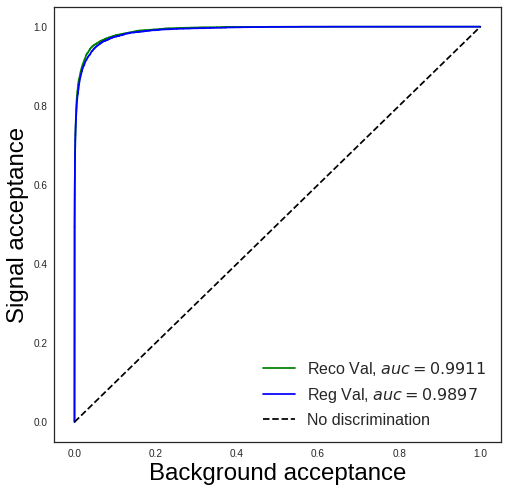

In [92]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(valData['gen_target'].values, recoPred)[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC), color='g')
plt.plot(*roc_curve(valData['gen_target'].values, regPred)[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC), color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

## Load

In [93]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    outputPipe = pickle.load(fin)